In [1]:
import os
import numpy as np
import time
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset, random_split
# from transformers import ConvNextForImageClassification нужен ли?
from torchvision.transforms.functional import to_pil_image
from torchvision import models,transforms

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from dataset import MNISTHAM10000
from utils import root, sorted_df_list, label_map, tensor_to_img, imgs_df, multiply_factor, itm_list, get_sampler_weight, get_class_weights
from model import initialize_model
from train import train_model, model_test, device

## Dataset

In [2]:
# загружаем подготовленный df 
imgs_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx,full_cell_type_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign keratosis-like lesions
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0,Actinic keratoses
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0,Actinic keratoses


In [3]:
# проверяем сбалансированность данных
imgs_df['full_cell_type_name'].value_counts()

full_cell_type_name
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

<Axes: xlabel='dx', ylabel='Count'>

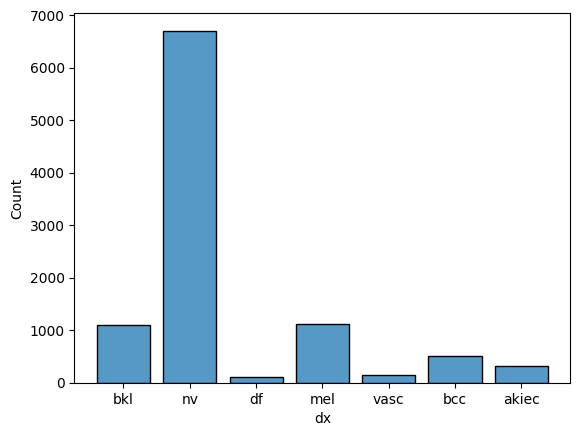

In [4]:
# проверяем сбалансированность данных
sns.histplot(data=imgs_df, x='dx', multiple="dodge", shrink=.8)

## Создаем рабочие данные для обучения и валидации

In [5]:
# задаем преобразования для данных
img_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
        ])

mask_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),  # Convert to PyTorch Tensor
        ])

In [6]:
# инициализуем класс MNISTHAM10000 (см. dataset.py) в котором балансируем данные за счет увеличения код-ва редких вариантов и применяет аугментация
# избежания переобучения
exm_dataset = MNISTHAM10000(root, imgs_df, True, multiply_factor(imgs_df), itm_list, img_transform, mask_transform)
# разбиваем данные на traun., val и test
train_dataset, val_dataset, test_dataset = random_split(exm_dataset, [0.8, 0.05, 0.15])

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False)

In [7]:
exm_dataset.multiply_factor

[6, 6, 13, 21, 47, 58]

In [8]:
# проверяем сбалонсированность классов после всех преобразований
exm_dataset.augmented_df['dx'].value_counts()

dx
mel      7791
bkl      7693
bcc      7196
akiec    7194
vasc     6816
df       6785
nv       6705
Name: count, dtype: int64

<Axes: xlabel='dx', ylabel='Count'>

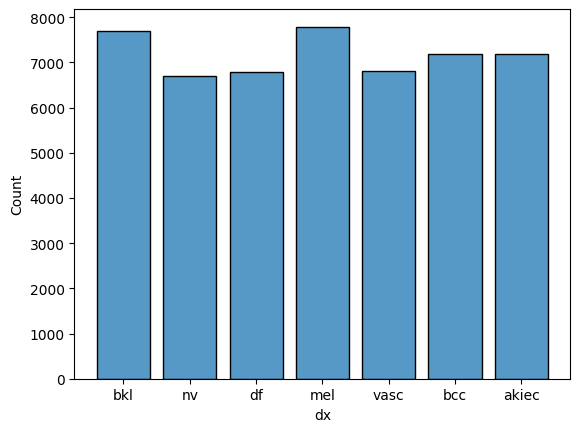

In [30]:
# соотношение классов до и после балансировки
sns.histplot(data=exm_dataset.augmented_df, x='dx', multiple="dodge", shrink=.8)

# sns.histplot(data=imgs_df, x='dx')

# Обучение CNN

## Densenet_121

[epoch 1], [iter 50/1255], [train loss 1.246], [train acc 0.551]
[epoch 1], [iter 100/1255], [train loss 1.170], [train acc 0.579]
[epoch 1], [iter 150/1255], [train loss 1.072], [train acc 0.610]
[epoch 1], [iter 200/1255], [train loss 1.012], [train acc 0.631]
[epoch 1], [iter 250/1255], [train loss 0.971], [train acc 0.646]
[epoch 1], [iter 300/1255], [train loss 0.929], [train acc 0.659]
[epoch 1], [iter 350/1255], [train loss 0.908], [train acc 0.666]
[epoch 1], [iter 400/1255], [train loss 0.878], [train acc 0.676]
[epoch 1], [iter 450/1255], [train loss 0.853], [train acc 0.685]
[epoch 1], [iter 500/1255], [train loss 0.838], [train acc 0.691]
[epoch 1], [iter 550/1255], [train loss 0.827], [train acc 0.694]
[epoch 1], [iter 600/1255], [train loss 0.813], [train acc 0.700]
[epoch 1], [iter 650/1255], [train loss 0.799], [train acc 0.705]
[epoch 1], [iter 700/1255], [train loss 0.790], [train acc 0.709]
[epoch 1], [iter 750/1255], [train loss 0.774], [train acc 0.715]
[epoch 1], 

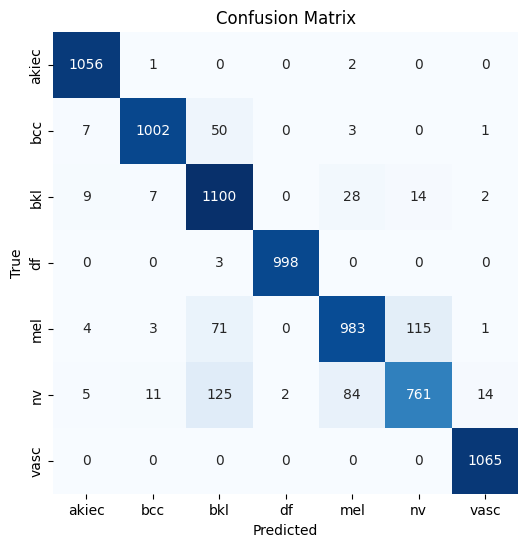

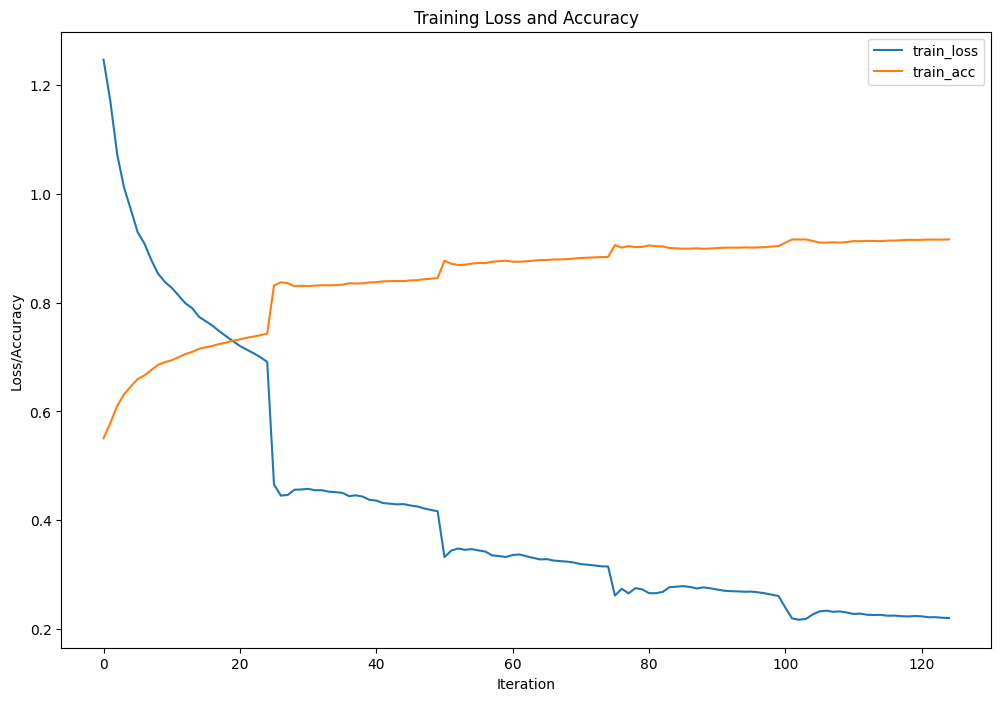

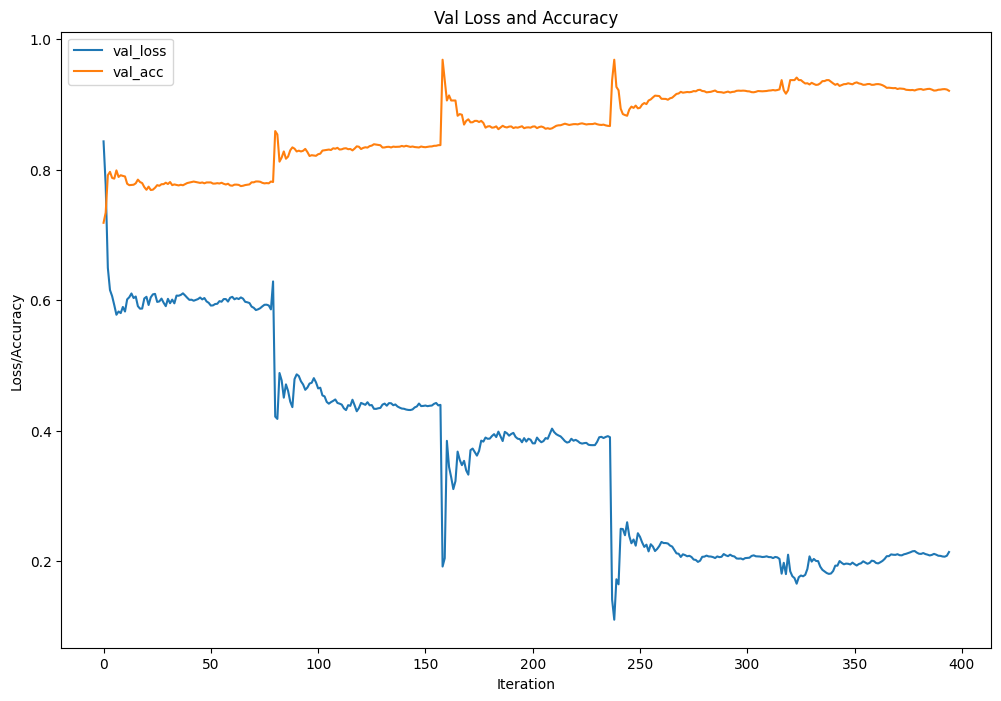

In [10]:
file = open("densenet_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

model_densenet = initialize_model('densenet', 7, False, use_pretrained='IMAGENET1K_V1')

optimizer = optim.Adam(model_densenet.parameters(), lr=0.001, weight_decay=1e-5) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_densenet, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_densenet, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, model_densenet, criterion, optimizer)

model_densenet.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, mask = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_densenet(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_densenet = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_densenet, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=sorted_df_list, #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=sorted_df_list #['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
            )
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# # Define the file path where you want to save the model
save_path = "model_densenet.pth"
# # # Save the trained model
# # torch.save(model_densenet.state_dict(), save_path)

torch.save(model_densenet, save_path)

## Resnet101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Igor/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 103MB/s]  


[epoch 1], [iter 50/1255], [train loss 1.560], [train acc 0.429]
[epoch 1], [iter 100/1255], [train loss 1.367], [train acc 0.493]
[epoch 1], [iter 150/1255], [train loss 1.278], [train acc 0.529]
[epoch 1], [iter 200/1255], [train loss 1.206], [train acc 0.558]
[epoch 1], [iter 250/1255], [train loss 1.155], [train acc 0.577]
[epoch 1], [iter 300/1255], [train loss 1.106], [train acc 0.596]
[epoch 1], [iter 350/1255], [train loss 1.069], [train acc 0.608]
[epoch 1], [iter 400/1255], [train loss 1.036], [train acc 0.619]
[epoch 1], [iter 450/1255], [train loss 1.016], [train acc 0.625]
[epoch 1], [iter 500/1255], [train loss 0.989], [train acc 0.636]
[epoch 1], [iter 550/1255], [train loss 0.968], [train acc 0.643]
[epoch 1], [iter 600/1255], [train loss 0.948], [train acc 0.651]
[epoch 1], [iter 650/1255], [train loss 0.926], [train acc 0.660]
[epoch 1], [iter 700/1255], [train loss 0.912], [train acc 0.664]
[epoch 1], [iter 750/1255], [train loss 0.895], [train acc 0.671]
[epoch 1], 

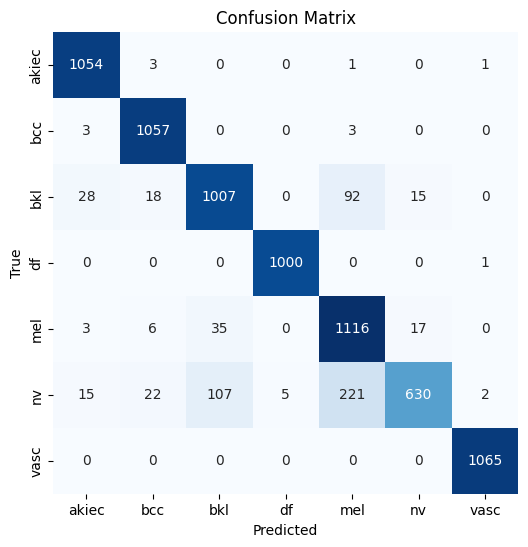

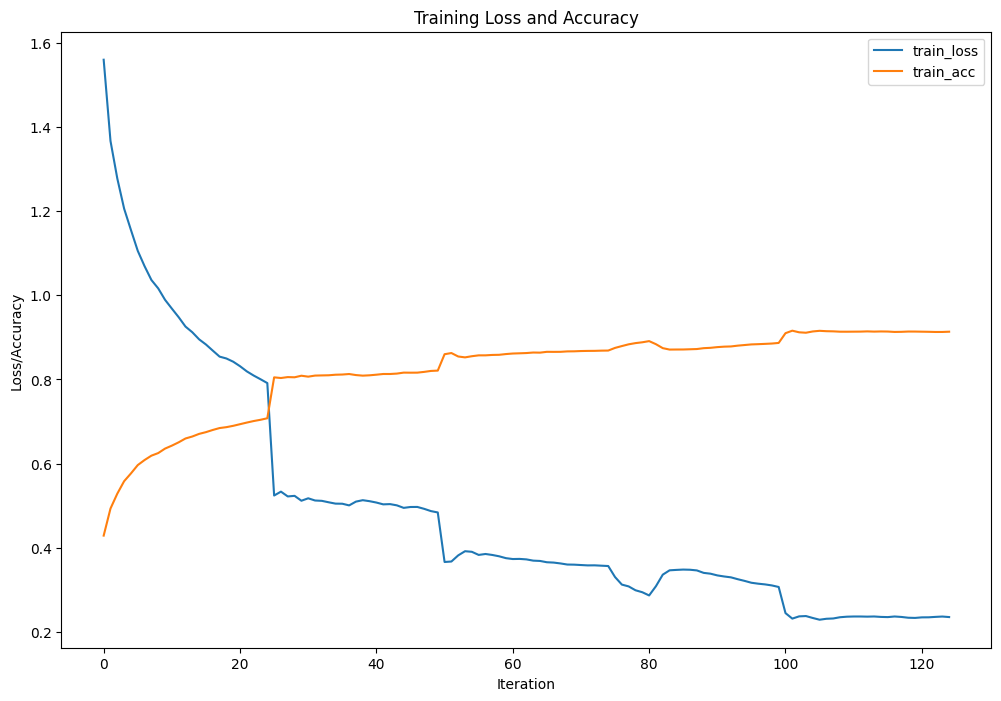

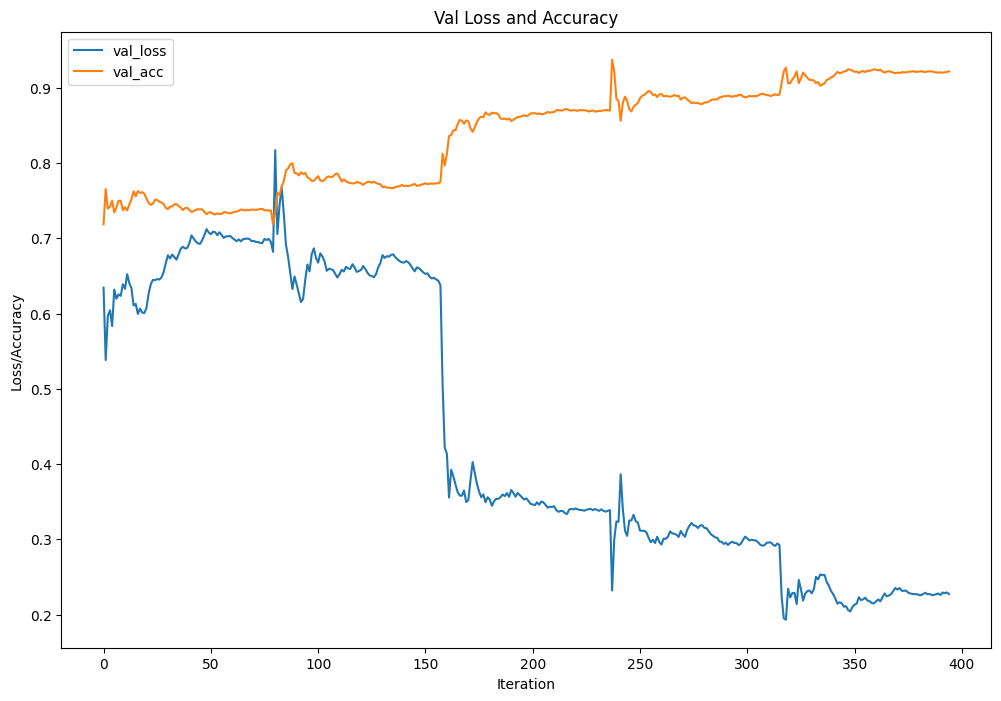

In [14]:
file = open("resnet_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

model_resnet = initialize_model('resnet', 7, False, use_pretrained='IMAGENET1K_V1')

optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3, weight_decay=1e-5) #model_ft.fc.parameters()
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_resnet, criterion, optimizer, epoch, 50)
    
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_resnet, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val
    
    writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')

file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, model_resnet, criterion, optimizer)

model_resnet.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, mask = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_resnet(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_resnet = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
save_path = "model_resnet.pth"
# Save the trained model
# torch.save(model_resnet.state_dict(), save_path)
torch.save(model_resnet, save_path)

## VGG_13_bn

[epoch 1], [iter 50/1255], [train loss 1.567], [train acc 0.425]
[epoch 1], [iter 100/1255], [train loss 1.427], [train acc 0.472]
[epoch 1], [iter 150/1255], [train loss 1.356], [train acc 0.502]
[epoch 1], [iter 200/1255], [train loss 1.284], [train acc 0.529]
[epoch 1], [iter 250/1255], [train loss 1.231], [train acc 0.550]
[epoch 1], [iter 300/1255], [train loss 1.186], [train acc 0.571]
[epoch 1], [iter 350/1255], [train loss 1.159], [train acc 0.585]
[epoch 1], [iter 400/1255], [train loss 1.133], [train acc 0.596]
[epoch 1], [iter 450/1255], [train loss 1.102], [train acc 0.607]
[epoch 1], [iter 500/1255], [train loss 1.079], [train acc 0.616]
[epoch 1], [iter 550/1255], [train loss 1.059], [train acc 0.624]
[epoch 1], [iter 600/1255], [train loss 1.042], [train acc 0.631]
[epoch 1], [iter 650/1255], [train loss 1.026], [train acc 0.637]
[epoch 1], [iter 700/1255], [train loss 1.009], [train acc 0.644]
[epoch 1], [iter 750/1255], [train loss 0.991], [train acc 0.650]
[epoch 1], 

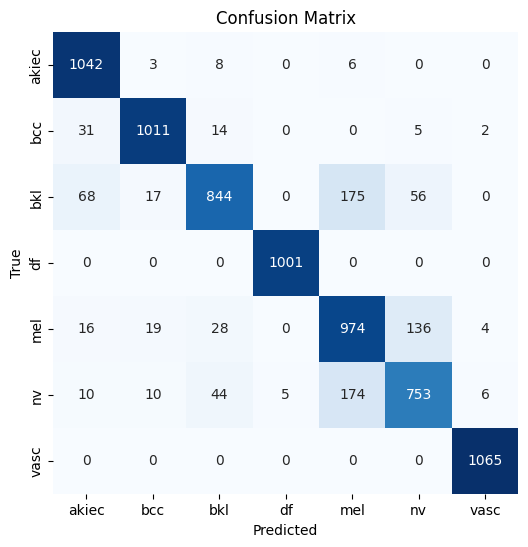

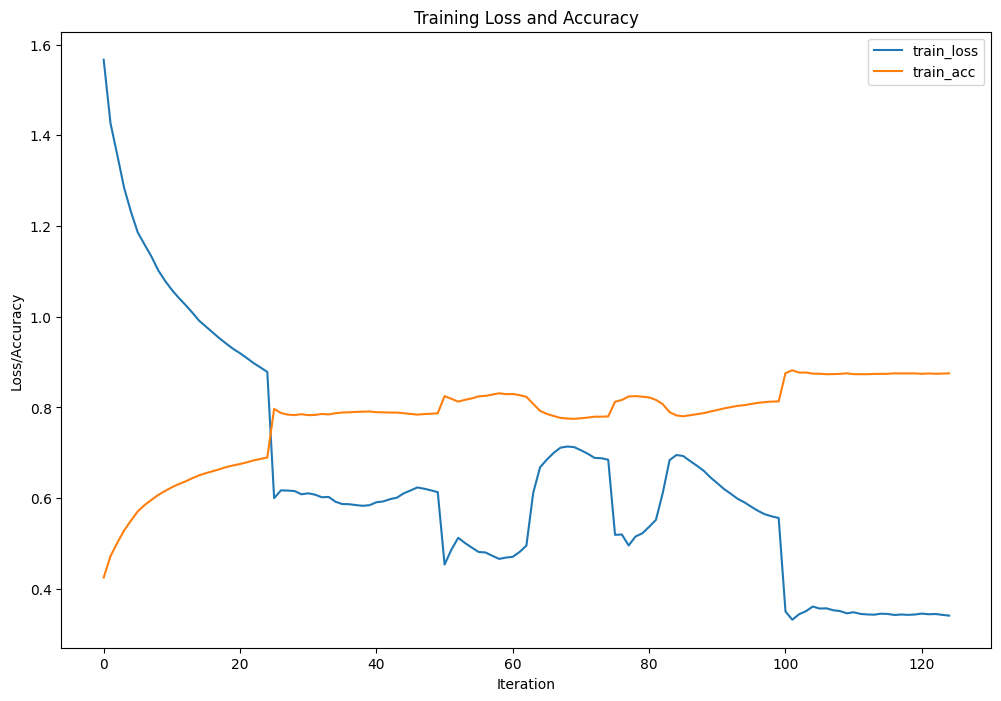

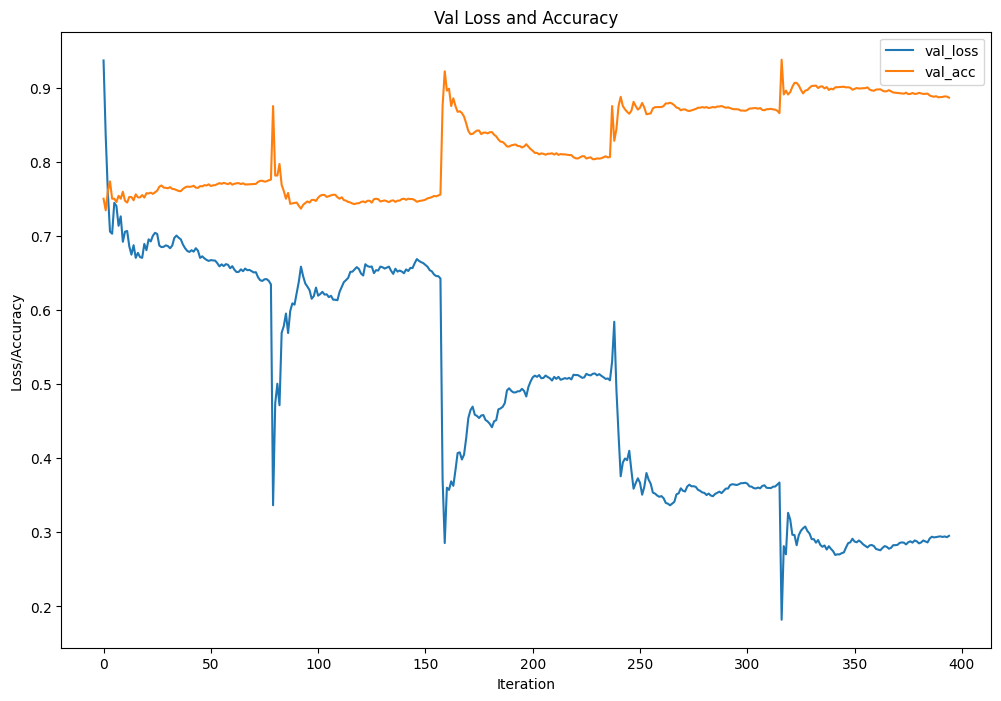

In [26]:
file = open("vgg13_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

model_vgg13 = initialize_model('vgg13', 7, False, use_pretrained='IMAGENET1K_V1')

optimizer = optim.Adam(model_vgg13.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train_vgg = []
total_acc_train_vgg = []

total_loss_val_vgg = []
total_acc_val_vgg = []

start_time = time.time()

epoch_num = 5
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(train_loader, model_vgg13, criterion, optimizer, epoch, 50)
    total_loss_train_vgg += loss_train
    total_acc_train_vgg += acc_train
    
    loss_val, acc_val = model_test(val_loader, model_vgg13, criterion, optimizer, True, epoch)

    total_loss_val_vgg += loss_val
    total_acc_val_vgg += acc_val
    
    writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')

file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, model_vgg13, criterion, optimizer)

model_vgg13.eval()
y_label_vgg = []
y_predict_vgg = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, mask = data
        N = images.size(0)
        images = images.to(device)
        outputs = model_vgg13(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label_vgg.extend(labels.cpu().numpy())
        y_predict_vgg.extend(np.squeeze(prediction.cpu().numpy().T))

report_vgg13 = classification_report(y_label_vgg, y_predict_vgg)
print(report_vgg13)

cm_vgg13 = confusion_matrix(y_label_vgg, y_predict_vgg)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_vgg13, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train_vgg, label="train_loss")
plt.plot(total_acc_train_vgg, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val_vgg, label="val_loss")
plt.plot(total_acc_val_vgg, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
save_path = "model_vgg13.pth"
# # Save the trained model
# torch.save(model_vgg.state_dict(), save_path)
torch.save(model_vgg13, save_path)

## Краткий вывод: ##
Вариант 1 является лучшей моделью среди трех:
- имеет самый низкий test loss (0.151), что указывает на лучшее качество предсказаний.
- демонстрирует самую высокую accuracy (0.940).
- показывает сбалансированные метрики для всех классов, включая macro avg и weighted avg (0.95).
- классы 2, 4, 5, хотя и имеют более низкие метрики, все же показывают лучшие результаты по сравнению с другими вариантами.

Вариант 2 занимает второе место:
- имеет чуть более высокий test loss и более низкую accuracy по сравнению с Вариантом 1.
- метрики для классов 2, 4, 5 ниже, чем в Варианте 1.

Вариант 3 является наименее эффективным:
- имеет самый высокий test loss и самую низкую accuracy.
- метрики для классов 2, 4, 5 значительно хуже, чем в других вариантах.
Как основная модель для дальнейшей работы был выбран Вариант 1 (модель densenet), так как он демонстрирует наилучшие результаты по всем ключевым метрикам.

# Обучение лучшей модели на всех данных и большем количестве эпох

[epoch 1], [iter 50/1569], [train loss 1.222], [train acc 0.557]
[epoch 1], [iter 100/1569], [train loss 1.111], [train acc 0.598]
[epoch 1], [iter 150/1569], [train loss 1.048], [train acc 0.616]
[epoch 1], [iter 200/1569], [train loss 0.996], [train acc 0.637]
[epoch 1], [iter 250/1569], [train loss 0.971], [train acc 0.644]
[epoch 1], [iter 300/1569], [train loss 0.943], [train acc 0.650]
[epoch 1], [iter 350/1569], [train loss 0.920], [train acc 0.658]
[epoch 1], [iter 400/1569], [train loss 0.889], [train acc 0.670]
[epoch 1], [iter 450/1569], [train loss 0.869], [train acc 0.676]
[epoch 1], [iter 500/1569], [train loss 0.853], [train acc 0.681]
[epoch 1], [iter 550/1569], [train loss 0.832], [train acc 0.688]
[epoch 1], [iter 600/1569], [train loss 0.813], [train acc 0.695]
[epoch 1], [iter 650/1569], [train loss 0.804], [train acc 0.699]
[epoch 1], [iter 700/1569], [train loss 0.794], [train acc 0.703]
[epoch 1], [iter 750/1569], [train loss 0.779], [train acc 0.708]
[epoch 1], 

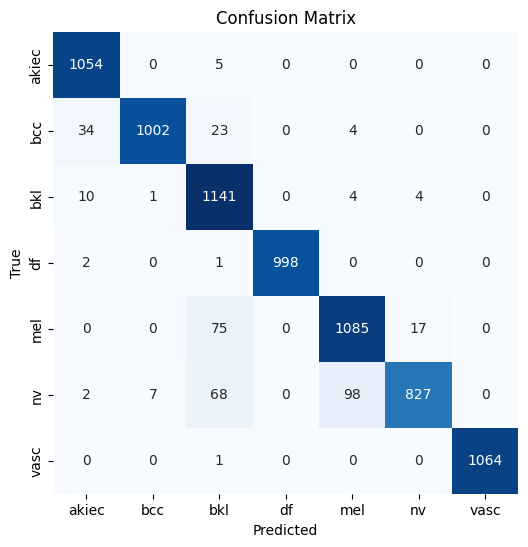

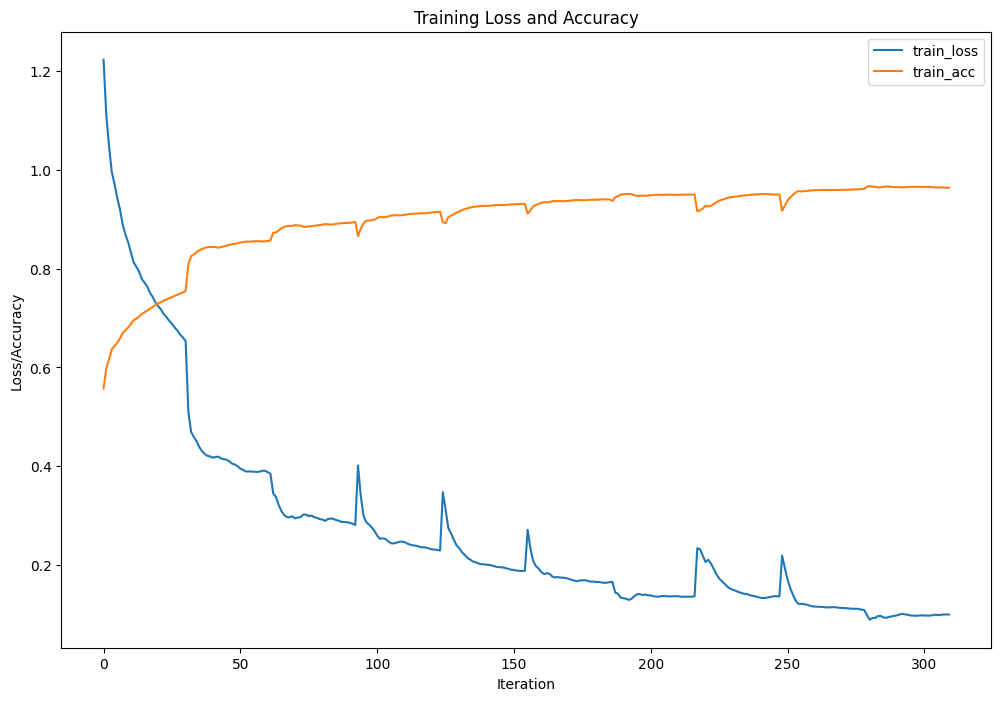

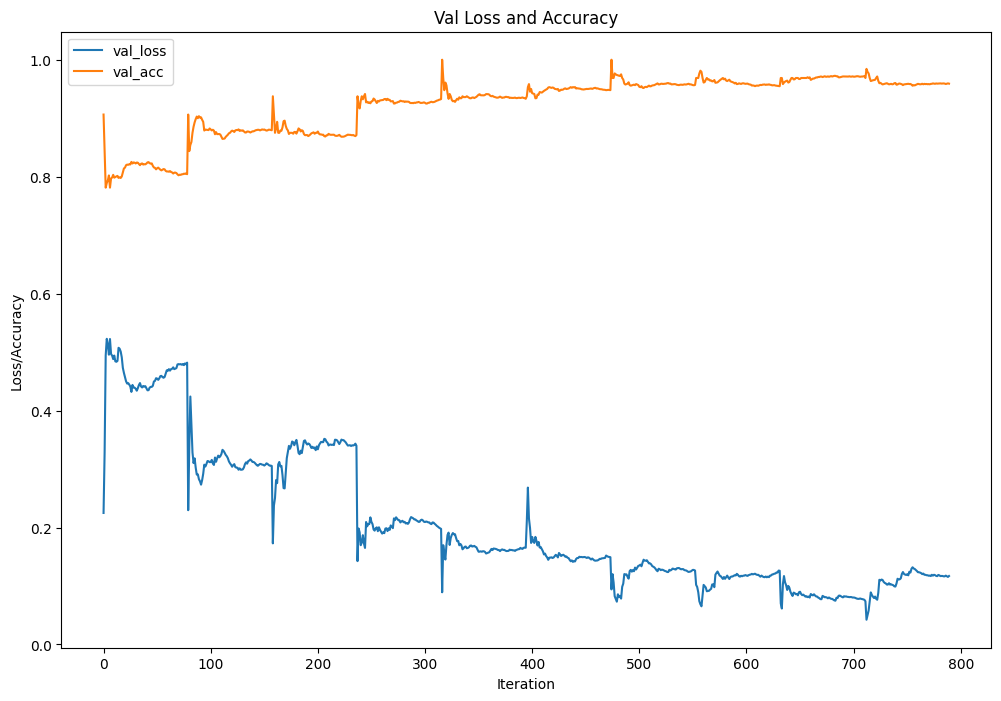

In [31]:
# создаем DataLoader со всеми данными
full_loader = DataLoader(
    exm_dataset, batch_size=32, shuffle=True)

# файл для логирования метрик train и val
file = open("full_densenet_training_logs.csv", mode="w", newline="")
writer = csv.writer(file)
writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

full_model_densenet = initialize_model('densenet', 7, False, use_pretrained='IMAGENET1K_V1')

optimizer = optim.Adam(full_model_densenet.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

total_loss_train = []
total_acc_train = []

total_loss_val = []
total_acc_val = []

start_time = time.time()

epoch_num = 10
for epoch in range(1, epoch_num+1):

    loss_train, acc_train = train_model(full_loader, full_model_densenet, criterion, optimizer, epoch, 50)
    total_loss_train += loss_train
    total_acc_train += acc_train
    
    loss_val, acc_val = model_test(val_loader, full_model_densenet, criterion, optimizer, True, epoch)
    
    total_loss_val += loss_val
    total_acc_val += acc_val

    writer.writerow([epoch, loss_train, acc_train, loss_val, acc_val])
    print('*****************************************************')
file.close()

end_time = time.time()
execution_time = end_time - start_time
print(f'train time: {round(execution_time/60, 2)} min')

total_loss_test, total_acc_test = model_test(test_loader, full_model_densenet, criterion, optimizer)

full_model_densenet.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels, mask = data
        N = images.size(0)
        images = images.to(device)
        outputs = full_model_densenet(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

report = classification_report(y_label, y_predict)
print(report)

cm_full_densenet = confusion_matrix(y_label, y_predict)
# Визуализация
plt.figure(figsize=(6, 6))
sns.heatmap(cm_full_densenet, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
            yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# визуализация train
plt.figure(figsize=(12,8))
plt.plot(total_loss_train, label="train_loss")
plt.plot(total_acc_train, label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# визуализация val
plt.figure(figsize=(12,8))
plt.plot(total_loss_val, label="val_loss")
plt.plot(total_acc_val, label="val_acc")
plt.title("Val Loss and Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Define the file path where you want to save the model
save_path = "full_model_densenet.pth"
# # Save the trained model
# torch.save(model_densenet.state_dict(), save_path)
torch.save(full_model_densenet, save_path)